<a href="https://colab.research.google.com/github/Vulpeszgg/study_NN_NEVOD-/blob/main/net2(EncoderDecoder).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1 loss: 0.07737326296916772, recall: 0.007565444357101327, precision: nan, IoU: 0.0010538042912468593
Epoch 2 loss: 0.007066109268839045, recall: 0.27239240087116157, precision: nan, IoU: 0.2548365635040138
Epoch 3 loss: 0.003917057836367357, recall: 0.5112253790982416, precision: 0.8210845812458858, IoU: 0.45823553496989133
Epoch 4 loss: 0.002891517404214453, recall: 0.5748495940014581, precision: 0.8256697429117755, IoU: 0.5121379452888096
Epoch 5 loss: 0.002297252379618933, recall: 0.7740178779463902, precision: 0.8371903517535914, IoU: 0.6722773165903358
Epoch 6 loss: 0.0019861061972452796, recall: 0.8077180065284265, precision: 0.8438551233750637, IoU: 0.7024114783679214
Epoch 7 loss: 0.0017700960242763928, recall: 0.8139437353499582, precision: 0.8547501625301682, IoU: 0.7148730459614335
Epoch 8 loss: 0.0016288724371610714, recall: 0.8216049038918218, precision: 0.8606148002860702, IoU: 0.724531607093098
Epoch 9 loss: 0.0015484630603508623, recall: 0.8542538950933474, preci

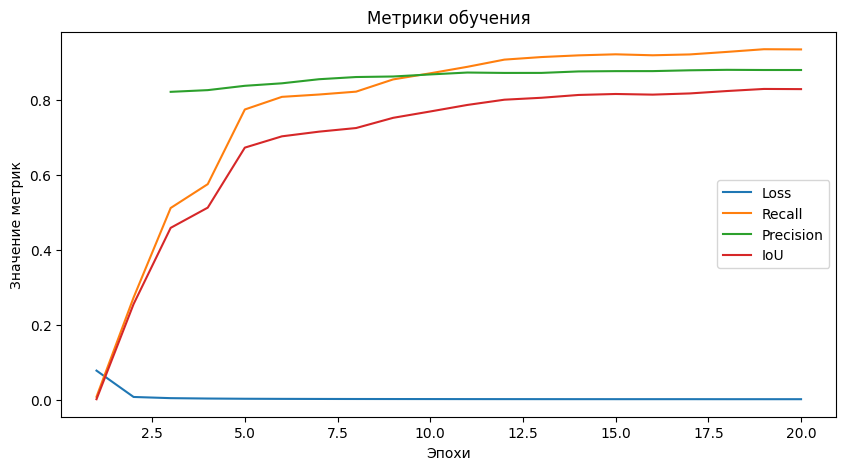

Test loss: 0.04604239761829376
Test recall: 0.9484991363759311, Test precision: 0.8611255209400969
False positive rate: 51.81092834472656
Test IoU: 0.8229363785599763


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split

# Загрузка данных
data = np.load('images_r.npy')
labels = np.load('masks_r.npy')

# Разбиение данных на train и test
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Преобразование данных в тензоры
train_data = torch.Tensor(train_data).cuda()
train_labels = torch.Tensor(train_labels).cuda()
test_data = torch.Tensor(test_data).cuda()
test_labels = torch.Tensor(test_labels).cuda()

# Определение модели
class ImprovedEncoderDecoder(nn.Module):
    def __init__(self):
        super(ImprovedEncoderDecoder, self).__init__()

        # Энкодер
        self.encoder_conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.encoder_conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.encoder_conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.encoder_conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout2d(p=0.2)
        self.encoder_pool = nn.MaxPool2d(2, 2)

        # Декодер
        self.decoder_upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.decoder_conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.decoder_conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(32)
        self.decoder_conv3 = nn.Conv2d(32, 16, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(16)
        self.dropout2 = nn.Dropout2d(p=0.2)
        self.decoder_conv4 = nn.Conv2d(16, 1, 3, padding=1)


    def forward(self, x):
        # Энкодер
        x = nn.functional.relu(self.bn1(self.encoder_conv1(x)))
        x = nn.functional.relu(self.bn2(self.encoder_conv2(x)))
        x = self.encoder_pool(nn.functional.relu(self.bn3(self.encoder_conv3(x))))
        x = self.dropout1(x)
        x = self.encoder_pool(nn.functional.relu(self.bn4(self.encoder_conv4(x))))

        # Декодер
        x = self.decoder_upsample(x)
        x = nn.functional.relu(self.bn5(self.decoder_conv1(x)))
        x = self.decoder_upsample(x)
        x = nn.functional.relu(self.bn6(self.decoder_conv2(x)))
        x = nn.functional.relu(self.bn7(self.decoder_conv3(x)))
        x = self.dropout2(x)
        x = torch.sigmoid(self.decoder_conv4(x))

        return x

# Создание экземпляра модели и определение функции потерь и оптимизатора
model = ImprovedEncoderDecoder().cuda()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())


import matplotlib.pyplot as plt

# Создание списков для хранения значений метрик
train_loss_values = []
train_recall_values = []
train_precision_values = []
train_iou_values = []

# Обучение модели
batch_size = 16
epochs = 20
num_batches = len(train_data) // batch_size
for epoch in range(epochs):
    running_loss = 0.0
    running_recall = 0.0
    running_precision = 0.0
    running_iou = 0.0

    for i in range(num_batches):
        # Обнуление градиентов перед каждой итерацией обучения
        optimizer.zero_grad()

        # Прямой проход
        batch_data = train_data[i*batch_size:(i+1)*batch_size]
        batch_labels = train_labels[i*batch_size:(i+1)*batch_size]
        outputs = model(batch_data.unsqueeze(1))
        loss = criterion(outputs, batch_labels.unsqueeze(1))
        running_loss += loss.item()

        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()

        # Расчет метрик recall и precision
        with torch.no_grad():
            predicted = (outputs > 0.5).float()
            true_positives = (predicted * batch_labels.unsqueeze(1)).sum()
            false_positives = (predicted * (1 - batch_labels.unsqueeze(1))).sum()
            false_negatives = ((1 - predicted) * batch_labels.unsqueeze(1)).sum()
            recall = true_positives / (true_positives + false_negatives)
            precision = true_positives / (true_positives + false_positives)
            running_recall += recall.item()
            running_precision += precision.item()

            # Расчет метрики IoU
            intersection = (predicted * batch_labels.unsqueeze(1)).sum()
            union = (predicted + batch_labels.unsqueeze(1)).sum() - intersection
            iou = intersection / union
            running_iou += iou.item()

    # Вывод loss, recall, precision и IoU на каждой эпохе
    avg_loss = running_loss / num_batches
    avg_recall = running_recall / num_batches
    avg_precision = running_precision / num_batches
    avg_iou = running_iou / num_batches
    print(f"Epoch {epoch+1} loss: {avg_loss}, recall: {avg_recall}, precision: {avg_precision}, IoU: {avg_iou}")

    # Добавление значений метрик в списки
    train_loss_values.append(avg_loss)
    train_recall_values.append(avg_recall)
    train_precision_values.append(avg_precision)
    train_iou_values.append(avg_iou)

# Построение графика изменения метрик во время обучения
plt.figure(figsize=(10, 5))
epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_loss_values, label='Loss')
plt.plot(epochs_range, train_recall_values, label='Recall')
plt.plot(epochs_range, train_precision_values, label='Precision')
plt.plot(epochs_range, train_iou_values, label='IoU')

plt.xlabel('Эпохи')
plt.ylabel('Значение метрик')
plt.title('Метрики обучения')
plt.legend()
plt.show()

# Тестирование модели
with torch.no_grad():
    model.eval()
    test_outputs = (model(test_data.unsqueeze(1)) > 0.5).float()
    test_loss = criterion(test_outputs, test_labels.unsqueeze(1))
    print(f"Test loss: {test_loss.item()}")
    batch_size = 16
    num_batches = len(test_data) // batch_size
    running_recall = 0.0
    running_precision = 0.0
    running_iou = 0.0  # Добавленная метрика IoU

    false_positive_pixels = 0  # счетчик пикселей, на которых был ненастоящий сигнал на входных данных, но на выходных данных его нет
    false_positive_total_pixels = 0  # общее количество пикселей с ненастоящим сигналом на входных данных
    for i in range(num_batches):
        batch_data = test_data[i * batch_size:(i + 1) * batch_size]
        batch_labels = test_labels[i * batch_size:(i + 1) * batch_size]
        outputs = model(batch_data.unsqueeze(1))
        predicted = (outputs > 0.5).float()
        true_positives = (predicted * batch_labels.unsqueeze(1)).sum()
        false_positives = (predicted * (1 - batch_labels.unsqueeze(1))).sum()
        false_negatives = ((1 - predicted) * batch_labels.unsqueeze(1)).sum()
        recall = true_positives / (true_positives + false_negatives)
        precision = true_positives / (true_positives + false_positives)
        running_recall += recall.item()
        running_precision += precision.item()
        false_positive_pixels += ((batch_data == 1) & (predicted == 0)).sum()
        false_positive_total_pixels += ((batch_data == 1) & (batch_labels == 0)).sum()

        # Расчет метрики IoU
        intersection = (predicted * batch_labels.unsqueeze(1)).sum()
        union = (predicted + batch_labels.unsqueeze(1)).sum() - intersection
        iou = intersection / union
        running_iou += iou.item()

    avg_recall = running_recall / num_batches
    avg_precision = running_precision / num_batches
    avg_iou = running_iou / num_batches

    print(f"Test recall: {avg_recall}, Test precision: {avg_precision}")
    false_positive_rate = false_positive_pixels / false_positive_total_pixels
    print(f"False positive rate: {false_positive_rate}")
    print(f"Test IoU: {avg_iou}")

import matplotlib.pyplot as plt

total_true_removed_signals = 0
total_predicted_removed_signals = 0
total_true_signals = 0
total_input_true_removed_signals = 0

for i in range(len(test_data)):
    # plt.matshow(test_data[i].cpu(), aspect='auto')
    # plt.title("Input")
    # plt.show()

    # plt.matshow(test_labels[i].cpu(), aspect='auto')
    # plt.title("True Mask")
    # plt.show()

    # plt.matshow((test_outputs[i, 0] > 0.5).float().cpu(), aspect='auto')
    # plt.title("Predicted Mask")
    # plt.show()

    input_signal = test_data[i].cpu().numpy()
    true_mask = test_labels[i].cpu().numpy()
    predicted_mask = (test_outputs[i, 0] > 0.5).float().cpu().numpy()

    # Calculate the number of signals on each line
    # print(f"Number of signals on each line:")
    for j in range(input_signal.shape[0]):
        line_input_signals = 0
        line_true_removed_signals = 0
        line_predicted_removed_signals = 0

        # Track the start of a continuous sequence of 1s
        start = -1
        for k in range(input_signal.shape[1]):
            if input_signal[j, k] == 1:
                if start == -1:
                    start = k
            else:
                if start != -1:
                    line_input_signals += 1
                    if np.all(true_mask[j, start:k] == 0):
                        line_true_removed_signals += 1
                        if np.all(predicted_mask[j, start:k] == 0):
                            line_predicted_removed_signals += 1
                    start = -1

        # Check if there is an ongoing sequence at the end
        if start != -1:
            line_input_signals += 1
            if np.all(true_mask[j, start:] == 0):
                line_true_removed_signals += 1
                if np.all(predicted_mask[j, start:] == 0):
                    line_predicted_removed_signals += 1

        # print(f"Line {j+1}: Input Signals: {line_input_signals}, True Removed Signals: {line_true_removed_signals}, Predicted Removed Signals: {line_predicted_removed_signals}")

        # Accumulate the total number of True Removed Signals and Predicted Removed Signals
        total_true_removed_signals += line_true_removed_signals
        total_predicted_removed_signals += line_predicted_removed_signals

        # Accumulate the total number of True Signals where input=1, true=1, and predicted=0
        total_input_true_removed_signals += np.sum((input_signal[j, :] == 1) & (true_mask[j, :] == 1) & (predicted_mask[j, :] == 0))

    # Calculate the total number of True Signals
    total_true_signals += np.sum(true_mask == 1)

    # print()

# Calculate the percentage of Predicted Removed Signals over True Removed Signals
percent_removed_predicted_true = (total_predicted_removed_signals / total_true_removed_signals) * 100
percent_removed_input_true = (total_input_true_removed_signals / total_true_signals) * 100

# print(f"Total True Removed Signals: {total_true_removed_signals}")
# print(f"Total Predicted Removed Signals: {total_predicted_removed_signals}")
# print(f"Percentage of Predicted Removed Signals / True Removed Signals: {percent_removed_predicted_true}%")
# print(f"Percentage of Input True Signals Removed / True Signals: {percent_removed_input_true}%")
